In [ ]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom, gaussian_filter
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def apply_blur(img, sigma=1.2):
    return gaussian_filter(img, sigma=sigma)


def compress_contrast(img, factor=0.85):
    mean = img.mean()
    return mean + factor * (img - mean)


def add_noise(img, sigma=0.02):
    noise = np.random.normal(0, sigma, img.shape)
    return img + noise


def simulate_low_field_deprecated(img, blur_sigma=1.2, contrast=0.85, noise_sigma=0.02):
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img = apply_blur(img, sigma=blur_sigma)
    img = compress_contrast(img, factor=contrast)
    img = add_noise(img, sigma=noise_sigma)

    return np.clip(img, 0, 1)

def simulate_low_field(img, blur_sigma=1.1, noise_sigma=0.015):
    # Normalize
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # 1. Blur
    img = gaussian_filter(img, sigma=blur_sigma)

    # 2. Darken intensities
    img = img ** 1.6

    # 3. Background-weighted noise
    noise = np.random.normal(0, noise_sigma, img.shape)
    noise = noise * (1 - img)

    img = img + noise
    return np.clip(img, 0, 1)

def convert_high_to_lowfield(
    input_path,
    output_path,
    target_shape=(112, 138, 40),
    target_spacing=(1.6, 1.6, 5.0),
    blur_sigma=1.2,
    contrast=0.85,
    noise_sigma=0.02
):
    print(f"\nProcessing: {input_path}")

    nii = nib.load(input_path)
    data = nii.get_fdata()
    affine = nii.affine

    original_spacing = nii.header.get_zooms()[:3]

    print("Original shape:", data.shape)
    print("Original spacing:", original_spacing)

    # Step 1: spacing-based resampling
    zoom_factors = [
        original_spacing[i] / target_spacing[i]
        for i in range(3)
    ]

    resampled = zoom(data, zoom_factors, order=1)

    # Step 2: force exact shape
    final_zoom = [
        target_shape[i] / resampled.shape[i]
        for i in range(3)
    ]

    final = zoom(resampled, final_zoom, order=1)

    print("Resampled shape:", final.shape)

    # Step 3: simulate low-field appearance
    final = simulate_low_field(
        final,
        blur_sigma=blur_sigma,
        noise_sigma=noise_sigma
    )

    # Step 4: new affine
    new_affine = np.copy(affine)
    new_affine[0, 0] = target_spacing[0]
    new_affine[1, 1] = target_spacing[1]
    new_affine[2, 2] = target_spacing[2]

    new_nii = nib.Nifti1Image(final.astype(np.float32), new_affine)
    nib.save(new_nii, output_path)

    print("Saved:", output_path)


def batch_convert(
    input_dir,
    output_dir,
    blur_sigma=1.1,
    contrast=0.85,
    noise_sigma=0.012
):
    os.makedirs(output_dir, exist_ok=True)

    for fname in os.listdir(input_dir):
        if fname.endswith(".nii") or fname.endswith(".nii.gz"):
            in_path = os.path.join(input_dir, fname)
            out_path = os.path.join(output_dir, fname)

            convert_high_to_lowfield(
                in_path,
                out_path,
                blur_sigma=blur_sigma,
                contrast=contrast,
                noise_sigma=noise_sigma
            )

def load_nii(path):
    nii = nib.load(path)
    return nii.get_fdata()

def normalize(img):
    img = img - img.min()
    img = img / (img.max() + 1e-8)
    return img


In [ ]:
base_dir = <BASE_DIR>

input_dir = os.path.join(base_dir, "train", "high_field")
output_dir = os.path.join(base_dir, "train", "synthetic_low_field")

print("Input:", input_dir)
print("Exists:", os.path.exists(input_dir))

batch_convert(
    input_dir,
    output_dir,
    blur_sigma=1.1,
    contrast=0.9,
    noise_sigma=0.012
)


Visualizing: sample_001
High: (179, 221, 200)
Synthetic: (112, 138, 40)
Real low: (112, 138, 40)


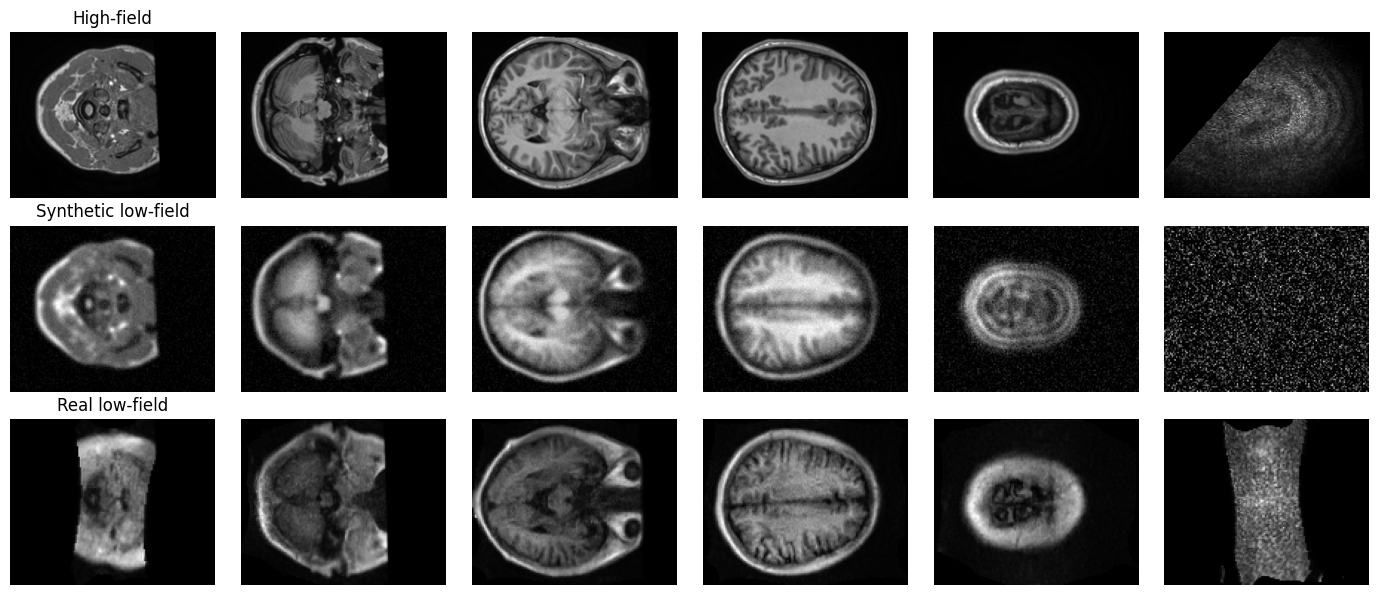


Visualizing: sample_002
High: (179, 221, 200)
Synthetic: (112, 138, 40)
Real low: (112, 138, 40)


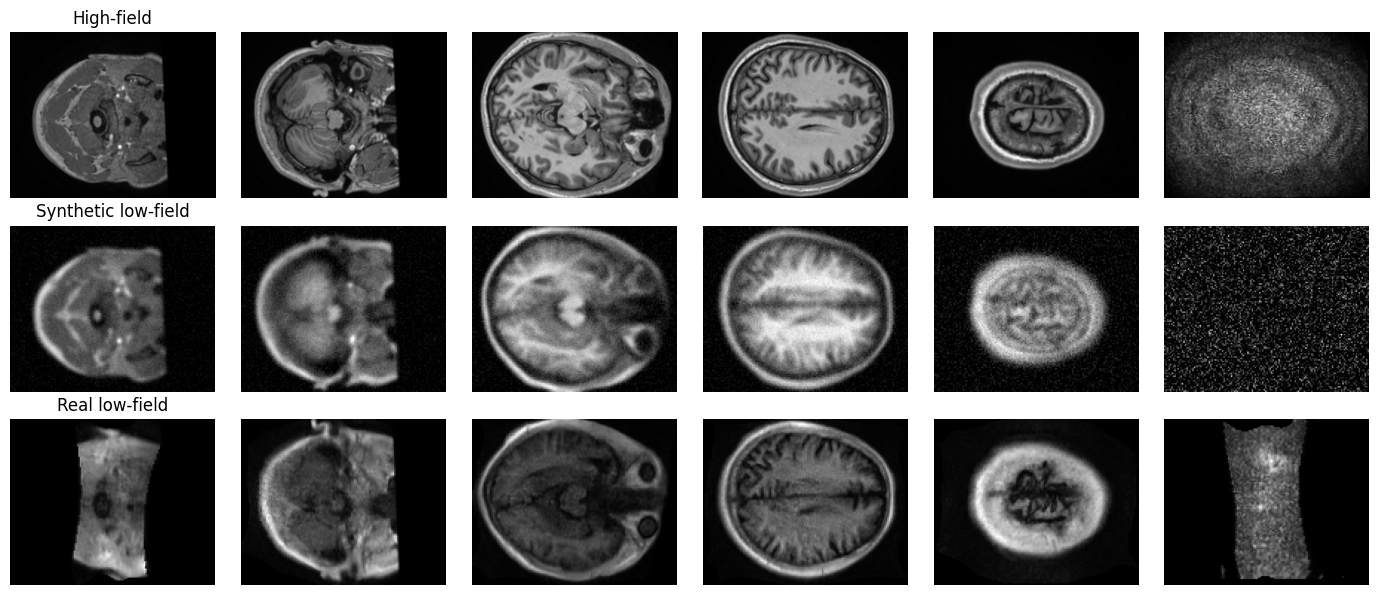


Visualizing: sample_003
High: (179, 221, 200)
Synthetic: (112, 138, 40)
Real low: (112, 138, 40)


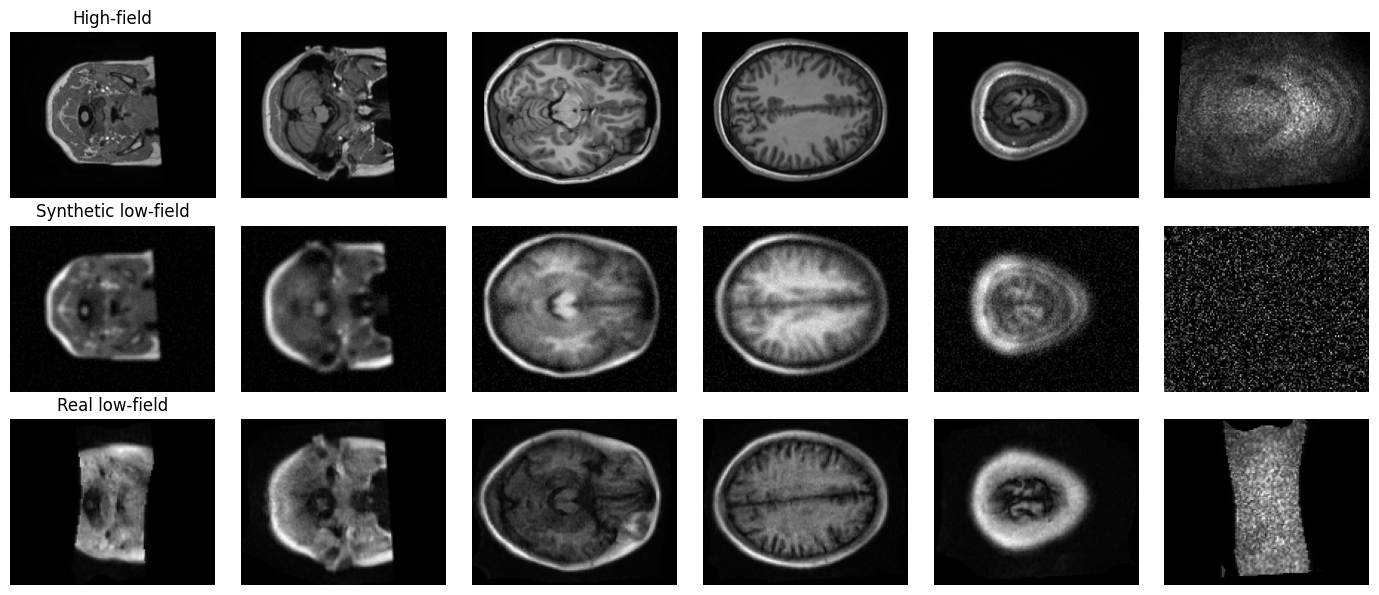

In [ ]:

def visualize_triplet(high_path, synthetic_path, real_low_path, num_slices=6):
    high = normalize(load_nii(high_path))
    synthetic = normalize(load_nii(synthetic_path))
    real_low = normalize(load_nii(real_low_path))

    high_slices = high.shape[2]
    syn_slices = synthetic.shape[2]
    low_slices = real_low.shape[2]

    print("High:", high.shape)
    print("Synthetic:", synthetic.shape)
    print("Real low:", real_low.shape)

    # Evenly spaced high-field slice indices
    high_indices = np.linspace(0, high_slices - 1, num_slices, dtype=int)

    plt.figure(figsize=(14, 6))

    for i, h_idx in enumerate(high_indices):
        # Map slices proportionally
        syn_idx = int(h_idx * (syn_slices / high_slices))
        low_idx = int(h_idx * (low_slices / high_slices))

        syn_idx = min(syn_idx, syn_slices - 1)
        low_idx = min(low_idx, low_slices - 1)

        # Row 1: High-field
        plt.subplot(3, num_slices, i + 1)
        plt.imshow(high[:, :, h_idx], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("High-field")

        # Row 2: Synthetic low-field
        plt.subplot(3, num_slices, num_slices + i + 1)
        plt.imshow(synthetic[:, :, syn_idx], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Synthetic low-field")

        # Row 3: Real low-field
        plt.subplot(3, num_slices, 2 * num_slices + i + 1)
        plt.imshow(real_low[:, :, low_idx], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Real low-field")

    plt.tight_layout()
    plt.show()


# -----------------------------
# Dataset-level visualization
# -----------------------------
def get_scan_id(fname):
    # Example:
    # sample_001_highfield.nii → sample_001
    return fname.split("_highfield")[0].split("_lowfield")[0]


def build_lookup(folder):
    lookup = {}
    for f in os.listdir(folder):
        if f.endswith(".nii") or f.endswith(".nii.gz"):
            scan_id = get_scan_id(f)
            lookup[scan_id] = f
    return lookup


def visualize_dataset(high_dir, syn_dir, low_dir, num_examples=3):
    high_lookup = build_lookup(high_dir)
    syn_lookup = build_lookup(syn_dir)
    low_lookup = build_lookup(low_dir)

    common_ids = sorted(
        set(high_lookup.keys())
        & set(syn_lookup.keys())
        & set(low_lookup.keys())
    )

    if not common_ids:
        print("No matching scans found across all folders.")
        return

    for scan_id in common_ids[:num_examples]:
        high_path = os.path.join(high_dir, high_lookup[scan_id])
        syn_path = os.path.join(syn_dir, syn_lookup[scan_id])
        low_path = os.path.join(low_dir, low_lookup[scan_id])

        print(f"\nVisualizing: {scan_id}")
        visualize_triplet(high_path, syn_path, low_path)



base_dir = "/Users/aritro/Aritro/mri-super-resolution-challenge-cs-gy-9223/train"

high_dir = os.path.join(base_dir, "high_field")
syn_dir = os.path.join(base_dir, "synthetic_low_field")
low_dir = os.path.join(base_dir, "low_field")

visualize_dataset(high_dir, syn_dir, low_dir, num_examples=3)